In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import time
import random
import logging

from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn import metrics as skm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder



logging.basicConfig(
    level=logging.INFO,
    #format="%(asctime)s %(message)s",
    format="%(message)s",
    handlers=[
        logging.FileHandler("{0}.log".format('pitch_prediction')),
        logging.StreamHandler()
    ])

logger = logging.getLogger()

pd.set_option('display.max_colwidth', -1)

In [35]:
# decode labels for outcomes and pitch types

# outcome codes
outcome_code = {
    'outcome_code' : ['B', '*B', 'S', 'C',
                      'F', 'T', 'L', 'I',
                      'W', 'M', 'P',
                      'Q','R', 'X',
                      'D', 'E', 'H',
                      'V', 'Z'],
    'outcome_description' : ['Ball', 'Ball in Dirt', 'Swinging Strike', 'Called Strike',
                            'Foul', 'Foul Tip', 'Foul Bunt', 'Intentional Ball',
                            'Swinging Strike (Blocked)', 'Missed Bunt', 'Pitchout',
                            'Swinging Pitchout', 'Foul Pitchout', 'In Play, Out(s)',
                            'In Play, No Outs', 'In Play, Runs', 'Hit by pitch',
                            'V', 'Z']
}
outcome_code = pd.DataFrame.from_dict(outcome_code)

pitch_code = {
    'pitch_code': ['CH', 'CU', 'EP', 'FC',
                   'FF', 'FO', 'FS', 'FT',
                   'IN', 'KC', 'KN',
                   'PO', 'SC', 'SI',
                   'SL', 'UN', 'FA', 'AB'],
    'pitch_description': ['Changeup', 'Curveball', 'Eephus', 'Cutter',
                          'Four-seam Fastball', 'Pitchout', 'Splitter', 'Two-seam Fastball',
                          'Intentionall ball', 'Knuckle curve', 'Knuckleball',
                          'Pitchout', 'Screwball', 'Sinker',
                          'Slider', 'Unknown', 'FA', 'AB']
}
pitch_code = pd.DataFrame.from_dict(pitch_code)

In [36]:
def load_data(num_rec=0):
    # specify subset of records to use
    if num_rec > 0:
        pitches = pd.read_csv("data/pitches.csv", nrows=num_rec)
    else:
        pitches = pd.read_csv("data/pitches.csv")
    atbats = pd.read_csv("data/atbats.csv")
    ejections = pd.read_csv("data/ejections.csv")
    games = pd.read_csv("data/games.csv")
    player_names = pd.read_csv("data/player_names.csv")



    # join all the data into all_df
    all_df = pd.merge(pitches, atbats, how='left',
            left_on = 'ab_id', right_on = 'ab_id')

    pitcher_df = player_names
    pitcher_df.columns = ['pitcher_id', 'pitcher_first_name', 'pitcher_last_name']

    all_df = pd.merge(all_df, pitcher_df, how='left',
            left_on = 'pitcher_id', right_on = 'pitcher_id')

    batter_df = player_names
    batter_df.columns = ['batter_id', 'batter_first_name', 'batter_last_name']

    all_df = pd.merge(all_df, batter_df, how='left',
            left_on = 'batter_id', right_on = 'batter_id')

    all_df = pd.merge(all_df, games, how='left',
            left_on = 'g_id', right_on = 'g_id')

    all_df = pd.merge(all_df, pitch_code, how='left',
            left_on = 'pitch_type', right_on = 'pitch_code')

    all_df = pd.merge(all_df, outcome_code, how='left',
            left_on = 'code', right_on = 'outcome_code')

    # extract weather conditions
    all_df['temp'] = all_df['weather'].str.extract(r'(\d+)')  # temperature
    all_df['temp'] = pd.to_numeric(all_df['temp'])
    all_df['weather_cond'] = all_df['weather'].str.extract(r'([^,]*$)')  # weather condition
    all_df['wind_mph'] = all_df['wind'].str.extract(r'(\d+)')  # wind speed
    all_df['wind_mph'] = pd.to_numeric(all_df['wind_mph'])
    all_df['wind_dir'] = all_df['wind'].str.extract(r'([^,]*$)')  # wind direction

    all_df.dropna(inplace=True)


    return all_df

def encode_data(df_in, x_col_list, y_col, avail_cols, y_encode='none', factor=np.nan):
    col_no_encode = []
    # we know there's one dependent variable to seed a dataframe
    y_df = df_in[[y_col]]
    encode_df = y_df

    for col in x_col_list:
        if avail_cols.get(col):
            # one-hot encode
            dummies_df = pd.get_dummies(df_in[col], prefix=col)
            encode_df = pd.concat([encode_df, dummies_df], axis=1)
        else:
            # just retrieve the column directly
            col_no_encode.append(col)

    encode_df = encode_df.drop([y_col], axis=1) # remove dependent variable seeding column
    X = pd.concat([encode_df, df_in[col_no_encode]], axis=1)

    if y_encode=='factorize':
        # use factorized y value
        y_return = factor[0]
    elif y_encode=='onehot':
        # one hot encode y values
        y_return = pd.get_dummies(y_df, prefix=y_col)
    else:
        y_return = y_df

    y = y_return

    return X, y


In [37]:
# functions to evaluate the results of different models and write to file

def format_cm(y_test_in, y_pred_in, factor_in):
    # confusion matrix
    y_test_label = factor_in[1][y_test_in]
    y_pred_label = factor_in[1][y_pred_in]
    cm = pd.DataFrame(
        confusion_matrix(y_test_label, y_pred_label, labels=list(factor_in[1])),
        index=list(factor_in[1]),
        columns=list(factor_in[1])
    )
    return cm


def eval_rf(y_test_in, y_pred_in, classifier_in, factor_in, idx_in, vars_in, elapsed_time):
    logger.info(f'\nRandom Forest Test ' + str(idx_in))
    logger.info(str(vars_in))

    # confusion matrix
    cm = format_cm(y_test_in, y_pred_in, factor_in)
    logger.info(cm)

    # print variable importance
    df_x_train = pd.DataFrame(X_train)

    feature_importances = pd.DataFrame(classifier_in.feature_importances_,
                                       index = df_x_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    train_col_df = pd.DataFrame(df_x_train.columns)
    fi = pd.merge(feature_importances, train_col_df, how='left',
            left_index = True, right_index = True)

    logger.info('\n' + str(fi.iloc[:20]))

    pscore = metrics.accuracy_score(y_test_in, y_pred_in)
    logger.info(f'Random Forest accuracy {pscore}')
    logger.info('Model time: %.1f [sec]' % (elapsed_time))

def eval_knn(y_test_in, y_pred_in, factor_in, idx_in, vars_in, elapsed_time):
    logger.info(f'\nKNN Test ' + str(idx_in))
    logger.info(str(vars_in))

    # confusion matrix
    cm = format_cm(y_test_in, y_pred_in, factor_in)
    logger.info(cm)

    # accuracy/time
    pscore = metrics.accuracy_score(y_test_in, y_pred_in)
    logger.info(f'KNN accuracy {pscore}')
    logger.info('Model time: %.1f [sec]' % (elapsed_time))

def eval_svc(y_test_in, y_pred_in, factor_in, idx_in, vars_in, elapsed_time):
    logger.info(f'\nSVC Test ' + str(idx_in))
    logger.info(str(vars_in))

    # confusion matrix
    cm = format_cm(y_test_in, y_pred_in, factor_in)
    logger.info(cm)

    # accuracy/time
    pscore = metrics.accuracy_score(y_test_in, y_pred_in)
    logger.info(f'SVC accuracy {pscore}')
    logger.info('Model time: %.1f [sec]' % (elapsed_time))

def eval_nn(y_test_in, y_pred_in, history_in, factor_in, idx_in, vars_in, elapsed_time_in):
    logger.info(f'\nNeural Net Test ' + str(idx_in))
    logger.info(str(vars_in))

    # model architecture
    print(str(model.summary()))
    logger.info(str(model.summary()))

    # accuracy/loss by epoch
    hist = pd.DataFrame(history_in.history)
    hist['epoch'] = history_in.epoch
    logger.info('\n' + str(hist))

    # plot
    acc = history_in.history['accuracy']
    val_acc = history_in.history['val_accuracy']
    loss = history_in.history['loss']
    val_loss = history_in.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # exit accuracy and loss
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    logger.info(f'\nExit test accuracy: {test_acc}')
    logger.info(f'Exit test loss: {test_loss}')

    # confusion matrix
    cm = format_cm(y_test_in, y_pred_in, factor_in)
    logger.info(cm)

    # accuracy/time
    pscore = metrics.accuracy_score(y_test_in, y_pred_in)
    logger.info(f'Neural Net accuracy {pscore}')
    logger.info('Model time: %.1f [sec]' % (elapsed_time_in))

In [38]:
# These are the values one can pass in as variables
# Values specify whether the column should be one-hot encoded
# Some are known at the time of pitch and some are outcomes of a pitch
avail_cols = {
    'px': False,        'pz': False,        'start_speed': False,   'end_speed': False,
    'spin_rate': False, 'spin_dir': False,  'break_angle': False,   'break_length': False,
    'break_y': False,   'ax': False,        'ay': False,            'az': False,
    'sz_bot': False,    'sz_top': False,    'type_confidence': True,'vx0': False,
    'vy0': False,       'vz0': False,       'x': False,             'x0': False,
    'y': False,         'y0': False,        'z0': False,            'pfx_x': False,
    'pfx_z': False,     'nasty': False,     'zone': True,           'code':	True,
    'type': True,       'pitch_type': True, 'event_num': False,     'b_score': False,
    'ab_id' : True,     'b_count': True,    's_count': True,        'outs': True,
    'pitch_num': False, 'on_1b': False,     'on_2b': False,         'on_3b': False,
    'batter_id': True,  'event': True,      'g_id': True,           'inning': True,     'o': True,
    'p_score': False,   'p_throws': True,   'pitcher_id': True,     'stand': True,      'top': False,
    'pitcher_first_name': True,     'pitcher_last_name': True,      'batter_first_name': True,
    'batter_last_name': True,       'attendance': False,            'away_final_score': False,
    'away_team': True,  'date': True,       'elapsed_time': False,  'home_final_score': False,
    'home_team': True,  'start_time': False, 'umpire_1B': True,      'umpire_2B': True,
    'umpire_3B': True,  'umpire_HP': True,  'venue_name': True,     'weather': True,
    'wind': True,       'delay': False,     'pitch_code': True,     'pitch_description': True,
    'outcome_code': True,           'outcome_description': True,    'temp': False,
    'weather_cond': True,           'wind_mph': False,              'wind_dir': True
}

Load the data from the files 

In [39]:
# load data, calculate new columns, join data - optional number of records parameter
all_df = load_data(10000) # pick the first n records if desired
#all_df = load_data()
#all_df = all_df[(all_df['date'] >= '2018-01-01') & (all_df['date'] <= '2018-12-31')]  # 2018

Data for baseline statistics

In [40]:
# pitch outcomes
outcome_df = all_df.groupby(['outcome_code', 'outcome_description']).size().reset_index(name='outcome_count')
outcome_df['outcome_prob']= outcome_df['outcome_count']/outcome_df['outcome_count'].sum()
outcome_df

,outcome_code,outcome_description,outcome_count,outcome_prob
0,*B,Ball in Dirt,188,0.018826
1,B,Ball,3257,0.326157
2,C,Called Strike,1768,0.177048
3,D,"In Play, No Outs",388,0.038854
4,E,"In Play, Runs",180,0.018025
5,F,Foul,1752,0.175446
6,H,Hit by pitch,29,0.002904
7,I,Intentional Ball,57,0.005708
8,L,Foul Bunt,22,0.002203
9,M,Missed Bunt,5,0.000501


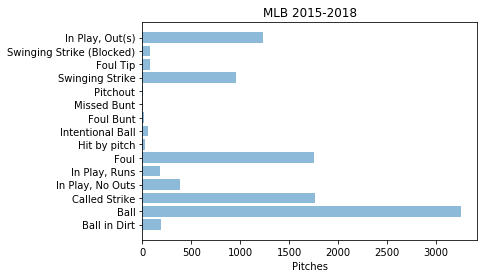

In [41]:
# bar chart of pitch outcomes
objects = outcome_df.outcome_description
y_pos = np.arange(len(outcome_df.outcome_description))
performance = outcome_df.outcome_count

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Pitches')
plt.title('MLB 2015-2018')

plt.show()

In [42]:
# pitch outcomes
pitch_df = all_df.groupby(['pitch_code', 'pitch_description']).size().reset_index(name='pitch_type_count')

pitch_df['pitch_prob']= pitch_df['pitch_type_count']/pitch_df['pitch_type_count'].sum()
pitch_df

,pitch_code,pitch_description,pitch_type_count,pitch_prob
0,CH,Changeup,972,0.097336
1,CU,Curveball,736,0.073703
2,EP,Eephus,2,0.000200
3,FC,Cutter,553,0.055378
4,FF,Four-seam Fastball,3444,0.344883
5,FO,Pitchout,2,0.000200
6,FS,Splitter,162,0.016223
7,FT,Two-seam Fastball,1387,0.138894
8,IN,Intentionall ball,57,0.005708
9,KC,Knuckle curve,175,0.017525


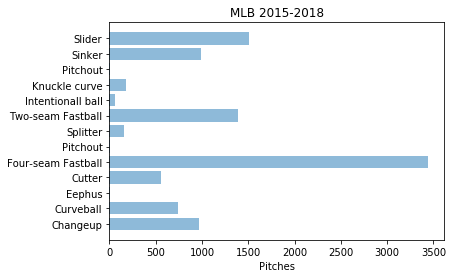

In [43]:
# bar chart of pitch types
objects = pitch_df.pitch_description
y_pos = np.arange(len(pitch_df.pitch_description))
performance = pitch_df.pitch_type_count

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Pitches')
plt.title('MLB 2015-2018')

plt.show()

In [44]:
# create one list of variables for each test you want to run
var_list = []

# this list has all the predictors known before a pitch takes place
# var_list.append(['b_score', 'b_count', 's_count','pitch_num', 'on_1b', 'on_2b', 'on_3b', 'batter_id', 'inning', 'o',
#                  'p_score', 'p_throws', 'stand', 'top', 'batter_id', 'pitcher_id',
#                  'away_team', 'home_team', 'umpire_HP','venue_name', 'temp', 'weather_cond',
#                  'wind_mph', 'wind_dir', 'delay'])

# this section for passing in fixed lists of predictors
# This list has the best prediction so far
var_list.append(['top', 'on_1b', 'on_2b', 'on_3b', 'o', 'p_score', 'stand', 'delay', 'b_count', 's_count',
               'pitcher_id', 'pitch_num'])
# var_list.append(['pitch_num', 'top', 'on_1b', 'on_2b', 'on_3b', 'o', 'p_score', 'stand', 'delay', 'b_count', 's_count', 'pitcher_id'])
fixed_vars = []

# this section for mixing a fixed number of predictors with a set number of predictors
# put the list of fixed predictors in the fixed_vars list
# put the mutually exclusive list of candidate predictors is the var_options list

# var_options = []
# fixed_vars  =['top', 'on_1b', 'on_2b', 'on_3b', 'o', 'p_score', 'stand', 'delay', 'b_count', 's_count',
#               'pitcher_id', 'pitch_num']
# var_options.append(['b_score', 'batter_id', 'inning', 'p_throws',
#                  'away_team', 'home_team', 'umpire_HP','venue_name', 'temp',
#                  'weather_cond', 'wind_mph', 'wind_dir'])
# var_list = list(combinations(var_options[0], 1))
# random.shuffle(var_list)


# factorize dependent variable
factor = pd.factorize(all_df['pitch_code'])
pitch_code_def = factor[1]


Linear Model (fails to converge)

In [45]:
# loop through different combinations of predictors and run linear model
# NOTE: the linear model doesn't converge
# for idx, vars in enumerate(var_list):
#     var1 = list(vars)
#     var1.extend(fixed_vars)
#     vars = var1
#
#     # one-hot encode all necessary data and split into test/training data
#     X, y = encode_data(all_df, x_col_list=vars, y_col='pitch_code', avail_cols=avail_cols,
#                        y_encode='factorize', factor=factor)
#
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
#
#     X_train = sklearn.preprocessing.scale(X_train, copy=False)
#     X_test = sklearn.preprocessing.scale(X_test, copy=False)
#
#     mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga').fit(X_train, y_train)

Start of Random Forest calculations

In [46]:
#loop through different combinations of predictors and run random forest calculations
for idx, vars in enumerate(var_list):

    # one-hot encode all necessary data and split into test/training data
    X, y = encode_data(all_df, x_col_list=vars, y_col='pitch_code', avail_cols=avail_cols,
                       y_encode='factorize', factor=factor)
    #X = sklearn.preprocessing.scale(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
    X_train = sklearn.preprocessing.scale(X_train, copy=False)
    X_test = sklearn.preprocessing.scale(X_test, copy=False)

    t1_start = time.perf_counter()

    # create and train random forest model
    classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42)
    classifier.fit(X_train, y_train)

    # predict test data
    y_pred = classifier.predict(X_test)

    t1_stop = time.perf_counter()
    elapsed_time = t1_stop - t1_start

    # print metrics for random forest model
    eval_rf(y_test, y_pred, classifier, factor, idx, vars, elapsed_time)


Random Forest Test 0
['top', 'on_1b', 'on_2b', 'on_3b', 'o', 'p_score', 'stand', 'delay', 'b_count', 's_count', 'pitcher_id', 'pitch_num']
     FF  CU  FC  SI  CH  FT  IN  SL  KC  EP  FS  FO  PO
FF  561  7   0   3   22  46  0   71  0   0   0   0   0 
CU  85   2   0   0   1   6   0   10  0   0   0   0   0 
FC  45   1   0   0   4   4   0   8   0   0   0   0   0 
SI  264  1   0   10  15  16  0   45  0   0   0   0   0 
CH  122  3   0   4   8   4   0   13  0   0   0   0   0 
FT  165  3   0   0   10  13  0   19  0   0   0   0   0 
IN  20   0   0   0   0   1   2   1   0   0   0   0   0 
SL  254  9   1   2   10  16  0   43  0   0   0   0   0 
KC  16   2   0   0   1   0   0   1   0   0   0   0   0 
EP  0    0   0   0   0   0   0   0   0   0   0   0   0 
FS  20   1   0   0   4   0   0   2   0   0   0   0   0 
FO  0    0   0   0   0   0   0   0   0   0   0   0   0 
PO  1    0   0   0   0   0   0   0   0   0   0   0   0 

     importance    0
264  0.076784    264
266  0.070504    266
261  0.03476

K-Nearest Neighbor

In [47]:
#loop through different combinations of predictors and run k-nearest neighbor
for idx, vars in enumerate(var_list):
    # add the fixed vars to the random ones
    var1 = list(vars)
    var1.extend(fixed_vars)
    vars = var1

    # one-hot encode all necessary data and split into test/training data
    X, y = encode_data(all_df, x_col_list=vars, y_col='pitch_code', avail_cols=avail_cols,
                       y_encode='factorize', factor=factor)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

    X_train = sklearn.preprocessing.scale(X_train, copy=False)
    X_test = sklearn.preprocessing.scale(X_test, copy=False)

    t1_start = time.perf_counter()

    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    t1_stop = time.perf_counter()
    elapsed_time = t1_stop - t1_start
    eval_knn(y_test, y_pred, factor, idx, vars, elapsed_time)


KNN Test 0
['top', 'on_1b', 'on_2b', 'on_3b', 'o', 'p_score', 'stand', 'delay', 'b_count', 's_count', 'pitcher_id', 'pitch_num']
     FF  CU  FC  SI  CH  FT  IN  SL  KC  EP  FS  FO  PO
FF  378  73  52  23  32  74  0   78  0   0   0   0   0 
CU  58   11  5   4   7   8   0   11  0   0   0   0   0 
FC  37   3   4   2   6   6   0   4   0   0   0   0   0 
SI  207  25  24  19  14  39  0   23  0   0   0   0   0 
CH  73   16  13  12  1   21  0   18  0   0   0   0   0 
FT  107  20  13  16  12  27  0   15  0   0   0   0   0 
IN  12   0   5   4   0   0   1   2   0   0   0   0   0 
SL  187  39  9   9   14  38  0   39  0   0   0   0   0 
KC  13   2   1   1   1   2   0   0   0   0   0   0   0 
EP  0    0   0   0   0   0   0   0   0   0   0   0   0 
FS  15   1   7   0   2   1   0   1   0   0   0   0   0 
FO  0    0   0   0   0   0   0   0   0   0   0   0   0 
PO  0    0   1   0   0   0   0   0   0   0   0   0   0 
KNN accuracy 0.24024024024024024
Model time: 9.2 [sec]


SVC

In [48]:
#loop through different combinations of predictors and run SVM calculations
for idx, vars in enumerate(var_list):

    # one-hot encode all necessary data and split into test/training data
    X, y = encode_data(all_df, x_col_list=vars, y_col='pitch_code', avail_cols=avail_cols,
                       y_encode='factorize', factor=factor)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
    X_train = sklearn.preprocessing.scale(X_train, copy=False)
    X_test = sklearn.preprocessing.scale(X_test, copy=False)

    # tuned the SVC model on a small (10K) number of records using grid search
    #params_grid = [{'kernel': ['rbf'], 'gamma': [0.1, 1, 10, 100], 'C': [0.1, 1, 10, 100, 1000]},
    #               {'kernel': ['poly'], 'degree': [1,2,3,4,5,6], 'C': [0.1, 1, 10, 100, 1000]}
    #               # ,{'kernel': ['linear'], 'C': [1, 10, 100, 1000]} # linear classifier not suitable for this data
    #               ]
    #svm_model = GridSearchCV(SVC(gamma='auto'), params_grid, cv=2)
    #print('Best score for training data:', svm_model.best_score_, "\n")
    #print('Best C:', svm_model.best_estimator_.C, "\n")
    #print('Best Kernel:', svm_model.best_estimator_.kernel, "\n")
    #print('Best Gamma:', svm_model.best_estimator_.gamma, "\n")
    #final_model = svm_model.best_estimator_

    t1_start = time.perf_counter()

    # used grid search to find best parameters
    final_model= SVC(C=1, kernel='poly', degree=1)
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)

    t1_stop = time.perf_counter()
    elapsed_time = t1_stop - t1_start

    eval_svc(y_test, y_pred, factor, idx, vars, elapsed_time)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)

SVC Test 0
['top', 'on_1b', 'on_2b', 'on_3b', 'o', 'p_score', 'stand', 'delay', 'b_count', 's_count', 'pitcher_id', 'pitch_num']
     FF  CU  FC  SI  CH  FT  IN  SL  KC  EP  FS  FO  PO
FF  695  0   0   0   0   1   0   14  0   0   0   0   0 
CU  103  0   0   0   0   0   0   1   0   0   0   0   0 
FC  62   0   0   0   0   0   0   0   0   0   0   0   0 
SI  325  0   0   24  0   0   0   2   0   0   0   0   0 
CH  148  0   0   4   0   0   0   2   0   0   0   0   0 
FT  199  0   0   0   0   11  0   0   0   0   0   0   0 
IN  24   0   0   0   0   0   0   0   0   0   0   0   0 
SL  324  0   0   2   0   1   0   8   0   0   0   0   0 
KC  11   0   0   4   0  

Start of Multi-layer network (MLP)

Train on 7988 samples, validate on 1998 samples
Epoch 1/10
7988/7988 [==============================] - 0s 33us/step - loss: 1.8232 - accuracy: 0.3860 - val_loss: 1.9820 - val_accuracy: 0.3243
Epoch 2/10
7988/7988 [==============================] - 0s 20us/step - loss: 1.3407 - accuracy: 0.4954 - val_loss: 2.0401 - val_accuracy: 0.2778
Epoch 3/10
7988/7988 [==============================] - 0s 20us/step - loss: 1.1973 - accuracy: 0.5174 - val_loss: 1.9807 - val_accuracy: 0.3113
Epoch 4/10
7988/7988 [==============================] - 0s 20us/step - loss: 1.1433 - accuracy: 0.5230 - val_loss: 1.9880 - val_accuracy: 0.3018
Epoch 5/10
7988/7988 [==============================] - 0s 20us/step - loss: 1.1033 - accuracy: 0.5362 - val_loss: 1.9682 - val_accuracy: 0.2893
Epoch 6/10
7988/7988 [==============================] - 0s 19us/step - loss: 1.0800 - accuracy: 0.5481 - val_loss: 1.9633 - val_accuracy: 0.3098
Epoch 7/10
7988/7988 [==============================] - 0s 24us/step - loss: 1.046


Neural Net Test 0
['top', 'on_1b', 'on_2b', 'on_3b', 'o', 'p_score', 'stand', 'delay', 'b_count', 's_count', 'pitcher_id', 'pitch_num']
None

   val_loss  val_accuracy      loss  accuracy  epoch
0  1.982016  0.324324      1.823216  0.385954  0    
1  2.040088  0.277778      1.340728  0.495368  1    
2  1.980667  0.311311      1.197300  0.517401  2    
3  1.987955  0.301802      1.143331  0.523035  3    
4  1.968183  0.289289      1.103328  0.536179  4    
5  1.963332  0.309810      1.079961  0.548072  5    
6  1.996645  0.300801      1.046872  0.559965  6    
7  1.978726  0.315315      1.025717  0.568227  7    
8  1.989763  0.291792      0.997098  0.581998  8    
9  2.009583  0.298298      0.983612  0.581748  9    


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               137216    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 13)                3341      
Total params: 271,885
Trainable params: 271,885
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               137216    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_____________________

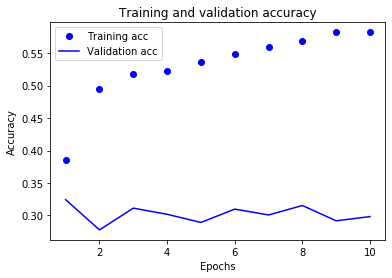


Exit test accuracy: 0.29829829931259155
Exit test loss: 2.0095834341851084
    CH  CU  EP  FC   FF  FO  FS  FT  IN  KC  PO  SI  SL
CH  14  9   0   0   96   0   0   14  0   0   0   4   17
CU  13  3   0   0   73   0   0   4   1   0   0   1   9 
EP  0   0   0   0   0    0   0   0   0   0   0   0   0 
FC  26  3   0   0   25   0   0   4   0   0   0   0   4 
FF  73  20  0   0   462  0   1   57  0   0   0   2   95
FO  0   0   0   0   0    0   0   0   0   0   0   0   0 
FS  5   1   0   0   18   0   3   0   0   0   0   0   0 
FT  15  8   0   0   142  0   0   19  0   4   0   0   22
IN  0   0   0   0   20   0   0   1   0   0   0   0   3 
KC  2   0   0   0   6    0   0   4   0   6   0   0   2 
PO  0   0   0   0   1    0   0   0   0   0   0   0   0 
SI  47  21  0   0   211  0   0   20  0   5   0   20  27
SL  29  12  0   0   190  0   0   31  0   0   0   4   69
Neural Net accuracy 0.2982982982982983
Model time: 2.2 [sec]


In [49]:
# loop through different combinations of predictors and run neural network calculations
for idx, vars in enumerate(var_list):
    # add the fixed vars to the random ones
    var1 = list(vars)
    var1.extend(fixed_vars)
    vars = var1

    # one-hot encode all necessary data and split into test/training data
    X, y = encode_data(all_df, x_col_list=vars, y_col='pitch_code', avail_cols=avail_cols,
                       y_encode='onehot', factor=factor)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

    X_train = sklearn.preprocessing.scale(X_train, copy=False)
    X_test = sklearn.preprocessing.scale(X_test, copy=False)

    t1_start = time.perf_counter()

    model = Sequential()
    model.add(Dense(512, input_dim=np.size(X_train,1), activation='relu'))
    model.add(Dense(256, input_dim=np.size(X_train,1), activation='relu'))
    model.add(Dense(np.size(y_train,1), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=512,
                        validation_data=(X_test, y_test),
                        verbose=True)

    y_pred = model.predict(X_test)

    #matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    t1_stop = time.perf_counter()
    elapsed_time = t1_stop - t1_start

    factor = pd.factorize([x.split('pitch_code_')[1] for x in y_test.columns])
    eval_nn(np.array(y_test).argmax(axis=1), y_pred.argmax(axis=1), history, factor, idx, vars, elapsed_time)